# Stubborn lamp

## Time series, rolling average

I've made a stubborn lamp. The lamp looks like this:

![](../files/2024-10-25-14-58-40.png)

But there is a catch. On the bottom of the lamp there is a turnable switch with which you can set the stubbornness for the lamp on a value from 0 to 100. Setting it to zero will make the lamp nice: of means of, on means on. But as the stubbornness goes up, the lamp takes more of a liberty to decide for itself. As the time goes up the chances of the lamp being where we've set it gets higher, and after about two minutes the lamp is always in the desired state.

A file is included containing all on/off times for the lamp at different stubbornness-settings. (This file is generated based on a translation of the Arduino code into python. The actual lamp would go through the settings randomly.) The lamp starts in the off-position and is turned on after 10 seconds. When the setting is zero, the lamp will do the following:

```
[[0, False], [10, True]]
```

But when the stubbornness setting is 10, the data will be:

```
[[0, False], [10, True], [16, False], [19, True], [55, False], [58, True]]
```

With a stubbornness of 100, there are about 20 state-changes. This is called a sparse data-set. Had the file contained a record for every second it would have been a dense dataset.

In [1]:
import json

# Load the JSON file
with open('../files/lamp_data.json', 'r') as file:
    lamp_data = json.load(file)

print(lamp_data["stubbornness_0"])

[[0, False], [10, True]]


## Data exploration

A graph is always a nice start. Lets graph stubbornness 0, 50 and 100 on a single graph.

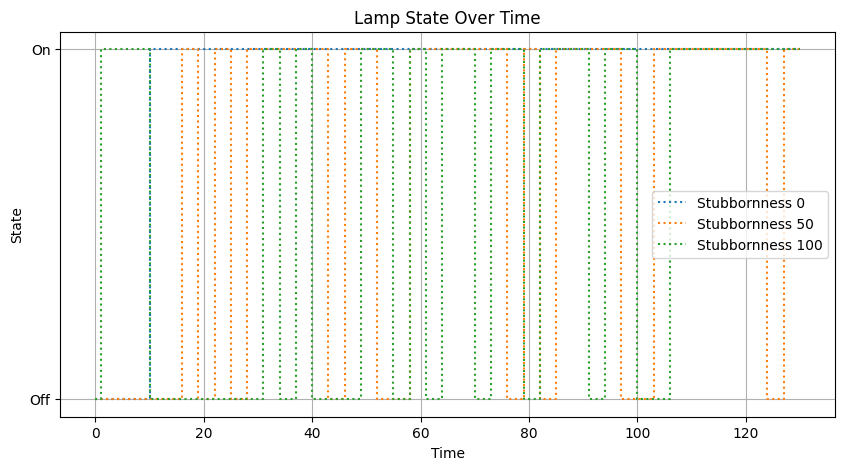

In [2]:
import matplotlib.pyplot as plt

# Plot the additional data
# Create the plot
plt.figure(figsize=(10, 5))

for keys in [0, 50, 100]:
    data = lamp_data[f'stubbornness_{keys}'].copy()
    data.append((130, True)) # needed to make sure all lines go all the way to the end
    time = [point[0] for point in data]
    state = [point[1] for point in data]
    state = [1 if s else 0 for s in state]
    plt.step(time, state, where='post', label=f'Stubbornness {keys}', linestyle=':')


plt.xlabel('Time')
plt.ylabel('State')
plt.title('Lamp State Over Time')
plt.yticks([0, 1], ['Off', 'On'])
plt.legend()
plt.grid(True)
plt.show()

What does this graph teach us? Close to nothing. It's just a bunch of lines that overlap. A statistical approach won't help us either:

In [3]:
import statistics

for keys in [0, 50, 100]:
    data = lamp_data[f'stubbornness_{keys}']
    print(f"Stubbornness {keys}: { statistics.mean([ d[1] for d in data]) }")

Stubbornness 0: 0.5
Stubbornness 50: 0.5
Stubbornness 100: 0.5


## Rolling average

The solution will be to use a rolling average, or "the change of the lamp being on in this timeframe." We can play around with the time-frame, make it too small (3 seconds) and the rolling average will be all over the place. Make it to big (130 seconds) and it will switch between 0 and 1. Let's try a rolling average on the stubbornness 50 with a window of 5.

In [4]:
import pandas as pd

# Create a DataFrame
data = lamp_data[f'stubbornness_50'].copy()
data.append((130,True))
df_new = pd.DataFrame(lamp_data[f'stubbornness_50'], columns=['time', 'state'])
df_new['state'] = df_new['state'].astype(int)
df_new['rolling_avg'] = df_new['state'].rolling(window=5).mean()
print(df_new)

    time  state  rolling_avg
0      0      0          NaN
1     16      1          NaN
2     19      0          NaN
3     22      1          NaN
4     25      0          0.4
5     28      1          0.6
6     43      0          0.4
7     46      1          0.6
8     52      0          0.4
9     58      1          0.6
10    76      0          0.4
11    79      1          0.6
12    82      0          0.4
13    85      1          0.6
14    97      0          0.4
15   103      1          0.6
16   124      0          0.4
17   127      1          0.6


A lot of 0.6 and .4. That's because our dataframe is unaware that the time column contains time. When working with time series it's essential to make sure pandas knows it is dealing with time related data.

(Note: This would have worked had we just registered the setting for the lamp for every second. That would have given us about 130 rows for every stubbornness, but for a stubbornness of 0 there would only have been 1 change. Let's try that!)

## Padding the data

The json-file only contains the datapoints where the state of the lamp changes (aka sparse). We'll use this to create a dataframe where there is a record for every second (aka dense). We'll also fill it up to 200 seconds, to make sure everybody is clear on the lamp being on. (This adding of datapoints at the end will be needed to allow a rolling average to come up to 1.)

In [5]:
def pad_data(data_row):
    i = 0
    val = False
    padded = []
    for time, value in data_row:
        while i < time:
            padded.append((i, val))
            i += 1
        val = value

    while i < 200:
        padded.append((i, val))
        i += 1
    return padded

padded_50 = pad_data(lamp_data[f'stubbornness_50'])

... and calculate the rolling average again. Let's do a whole bunch of them!

In [6]:
import pandas as pd

# Create a DataFrame
df_new = pd.DataFrame(padded_50, columns=['time', 'state'])
df_new['state'] = df_new['state'].astype(int)
for i in [5, 15, 30, 50]:
    df_new[f'rolling_avg_{i}'] = df_new['state'].rolling(window=i).mean()
print(df_new)

     time  state  rolling_avg_5  rolling_avg_15  rolling_avg_30  \
0       0      0            NaN             NaN             NaN   
1       1      0            NaN             NaN             NaN   
2       2      0            NaN             NaN             NaN   
3       3      0            NaN             NaN             NaN   
4       4      0            0.0             NaN             NaN   
..    ...    ...            ...             ...             ...   
195   195      1            1.0             1.0             1.0   
196   196      1            1.0             1.0             1.0   
197   197      1            1.0             1.0             1.0   
198   198      1            1.0             1.0             1.0   
199   199      1            1.0             1.0             1.0   

     rolling_avg_50  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
..              ...  
195             1.0  
196             1.0

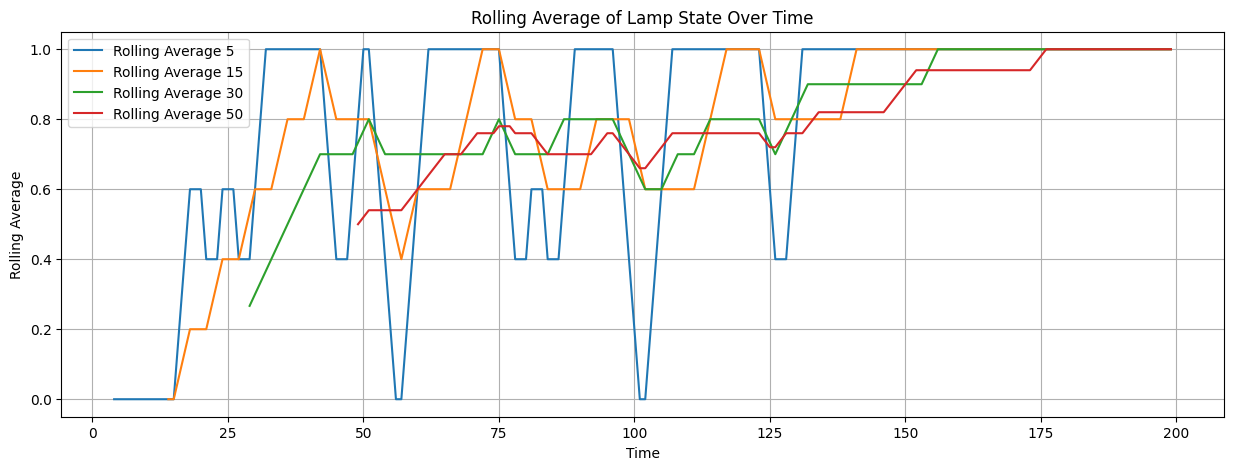

In [7]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(15, 5))

for i in [5, 15, 30, 50]:
    plt.plot(df_new['time'], df_new[f'rolling_avg_{i}'], label=f'Rolling Average {i}')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Rolling Average')
plt.title('Rolling Average of Lamp State Over Time')
plt.legend()
plt.grid(True)
plt.show()

Going over them:

* 5: is all over the place. Windows is too small.
* 15: starts early enough and is much smoother.
* 30: starts pretty late and isn't much smoother than 15.
* 50: misses 1/3 of the usefull samples before beginning and is a bit to smooth. Too big in this case.

So we land on a window of 15. Now let's compare this for the other datarows.

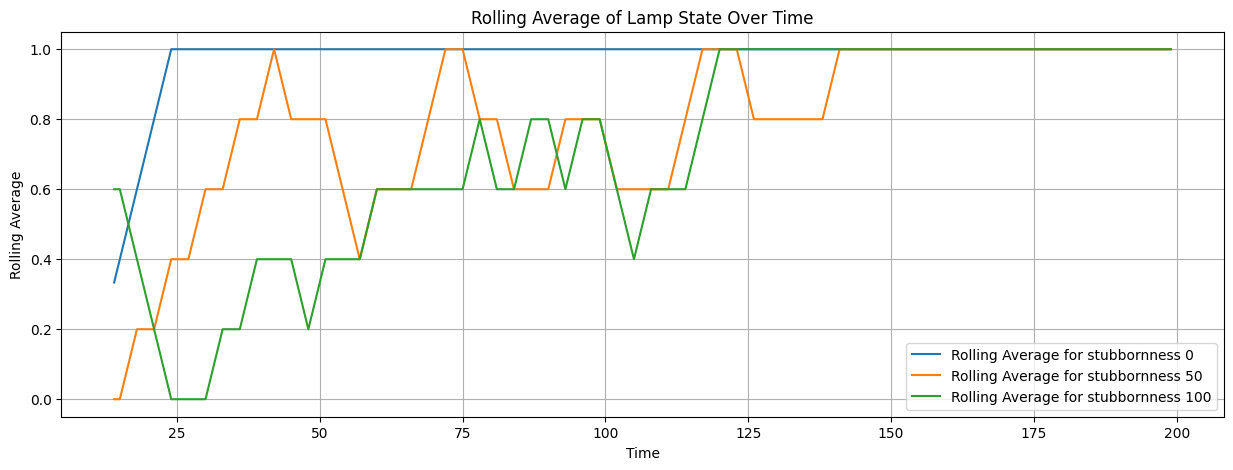

In [8]:
plt.figure(figsize=(15, 5))

for keys in [0, 50, 100]:
    data = pad_data(lamp_data[f'stubbornness_{keys}'].copy())
    df_new = pd.DataFrame(data, columns=['time', 'state'])
    df_new['state'] = df_new['state'].astype(int)
    df_new[f'rolling_avg_15'] = df_new['state'].rolling(window=15).mean()
    plt.plot(df_new['time'], df_new[f'rolling_avg_15'], label=f'Rolling Average for stubbornness {keys}')

plt.xlabel('Time')
plt.ylabel('Rolling Average')
plt.title('Rolling Average of Lamp State Over Time')
plt.legend()
plt.grid(True)
plt.show()

What to see?

* 0 starts to late. We should have padded additional data in the beginning just as we did at the end.
* 50 is off after 100 has already went to the desired state. This would indicate 50 being more annoying than 100.
* 100 is lower more than 50. This show that 100 is indeed more annoying than 50 as the chances of 50 being in the desired state are higher.

But now we padded the data, meaning we manually had to add extra rows to our data. We didn't make anything up, but shouldn't pandas be able to handle this type of data by itself?

## Entering time related data

Up until now, pandas was unaware of our data being time-related data. It's not because we had a column called 'time' that the data in this column was interpreted in that way. We'll start by creating a dataframe for only the stubborness 50.

In [9]:
data = lamp_data[f'stubbornness_50'].copy()
data.append((200,True))
df_new = pd.DataFrame(data, columns=['time', 'state'])
df_new['state'] = df_new['state'].astype(int)
df_new['time'] = pd.arrays.SparseArray(df_new['time'])
df_new['time'] = pd.to_datetime(df_new['time'], unit='s')
df_new.set_index('time', inplace=True)

df_new.head()

,state
time,
1970-01-01 00:00:00,0
1970-01-01 00:00:16,1
1970-01-01 00:00:19,0
1970-01-01 00:00:22,1
1970-01-01 00:00:25,0


Plotting the data won't show us anything, but it's to easy not to show.

<Axes: xlabel='time'>

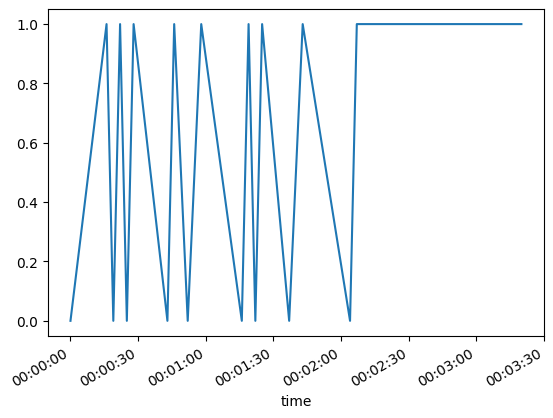

In [10]:
df_new.state.plot()

In fact it _did_ show us something new: pandas assumes it knows nothing of the state of the lamp between the state changes when in fact it does (it's the last state). If we keep on working with this data, we'll get some odd results. Like when calculating a rolling average...

(Note: the rolling window now has a unit, seconds or 's'.)

In [11]:
df_new['rolling_avg'] = df_new['state'].rolling(window='15s').mean()
print(df_new)

                     state  rolling_avg
time                                   
1970-01-01 00:00:00      0     0.000000
1970-01-01 00:00:16      1     1.000000
1970-01-01 00:00:19      0     0.500000
1970-01-01 00:00:22      1     0.666667
1970-01-01 00:00:25      0     0.500000
1970-01-01 00:00:28      1     0.600000
1970-01-01 00:00:43      0     0.000000
1970-01-01 00:00:46      1     0.500000
1970-01-01 00:00:52      0     0.333333
1970-01-01 00:00:58      1     0.666667
1970-01-01 00:01:16      0     0.000000
1970-01-01 00:01:19      1     0.500000
1970-01-01 00:01:22      0     0.333333
1970-01-01 00:01:25      1     0.500000
1970-01-01 00:01:37      0     0.500000
1970-01-01 00:01:43      1     0.500000
1970-01-01 00:02:04      0     0.000000
1970-01-01 00:02:07      1     0.500000
1970-01-01 00:03:20      1     1.000000


Take the average for the third row:

```
1970-01-01 00:00:19      0     0.500000
```

It's 0,5, as in the 15 seconds before we had 2 states:

* 0 at 16 seconds
* 1 at 19 seconds

Where we actually had

* 4s  -> 15s: 0
* 16s -> 19s: 1
* 19s: 0

So it should have been ((15-4) * 0 + (19 - 16) * 1) / 15 or 0.2, not 0.5.

The way pandas handles our data is fine in some cases, but not this case. To get the numbers correctly we'll need to add the duration of the lamp being on (or off) at any given time.

In [12]:
df_new['duration'] = (df_new.index.to_series().shift(-1) - df_new.index).fillna(pd.Timedelta(seconds=0))
df_new['weighted_state'] = df_new['state'] * df_new['duration'].dt.total_seconds()

df_new['rolling_avg'] = df_new['weighted_state'].rolling(window='15s').mean()

print(df_new)


                     state  rolling_avg        duration  weighted_state
time                                                                   
1970-01-01 00:00:00      0         0.00 0 days 00:00:16             0.0
1970-01-01 00:00:16      1         3.00 0 days 00:00:03             3.0
1970-01-01 00:00:19      0         1.50 0 days 00:00:03             0.0
1970-01-01 00:00:22      1         2.00 0 days 00:00:03             3.0
1970-01-01 00:00:25      0         1.50 0 days 00:00:03             0.0
1970-01-01 00:00:28      1         4.20 0 days 00:00:15            15.0
1970-01-01 00:00:43      0         0.00 0 days 00:00:03             0.0
1970-01-01 00:00:46      1         3.00 0 days 00:00:06             6.0
1970-01-01 00:00:52      0         2.00 0 days 00:00:06             0.0
1970-01-01 00:00:58      1         8.00 0 days 00:00:18            18.0
1970-01-01 00:01:16      0         0.00 0 days 00:00:03             0.0
1970-01-01 00:01:19      1         1.50 0 days 00:00:03         

Still wrong! Average at 19 seconds is now 1.5, which is the average of the two durations at 19s and 16s.

The only way of fixing this while keeping the dataset sparse is by calculating an extra column based on the windows. This gets really complicated really fast. So this is the point at which we realize the data we have  should have been dense from the beginning.

In [13]:
data = lamp_data[f'stubbornness_50'].copy()
data.append((200,True))
df_dense = pd.DataFrame(data, columns=['time', 'state'])
df_dense['state'] = df_dense['state'].astype(int)
df_dense['time'] = pd.to_datetime(df_dense['time'], unit='s')
df_dense.set_index('time', inplace=True)
df_dense = df_dense.resample('1s').ffill()
df_dense['rolling_avg'] = df_dense['state'].rolling(window='15s').mean()

df_dense

,state,rolling_avg
time,,
1970-01-01 00:00:00,0,0.0
1970-01-01 00:00:01,0,0.0
1970-01-01 00:00:02,0,0.0
1970-01-01 00:00:03,0,0.0
1970-01-01 00:00:04,0,0.0
...,...,...
1970-01-01 00:03:16,1,1.0
1970-01-01 00:03:17,1,1.0
1970-01-01 00:03:18,1,1.0


Quick and dirty plot of these two values?

<Axes: xlabel='time'>

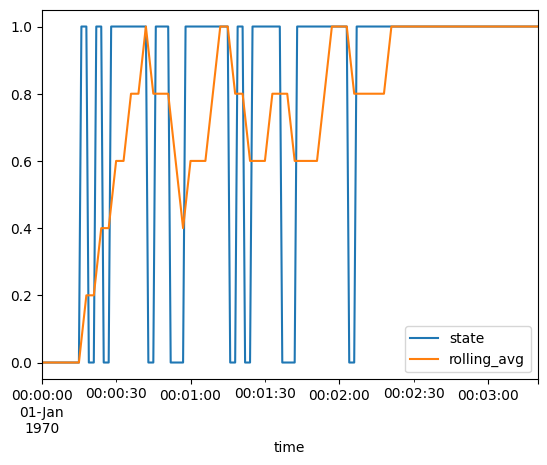

In [14]:
df_dense[['state', 'rolling_avg']].plot()

## Conclusion

When dealing with time-related data a rolling average is a good way of smoothing out the data to explore what is happening. It has other benefits that we can't do in this dataset. These include:

* Noise Reduction
* Trend Detection
* Outlier Detection

Do remember to always set the index of your dataframe to the column containing the time-data, as it will make your life (or at least the programming part of it) much easier. Also don't be afraid to switch to a dense set if that is how the data works (and if it's possible).

### Dense datasets

Benefits:

1. Simplicity and Compatibility:

    Dense datasets are easier to work with in pandas and other data processing libraries since most functions are designed with dense data in mind. This compatibility simplifies calculations like rolling averages, aggregations, and other window functions.

2. Continuous Data Representation:

    Dense datasets are particularly beneficial when analyzing data over continuous time intervals or sequences. If you need data points at regular intervals (e.g., every second or minute), a dense dataset lets you apply transformations directly, without needing to handle missing values.

3. Improved Handling of Complex Calculations:

    Operations involving time-weighted averages, cumulative calculations, or complex aggregations can often be performed more accurately and easily on dense datasets since you don’t need to account for missing data points.

4. Ease of Visualization and Plotting:

    Dense data is also more straightforward to plot, as it doesn't have gaps or missing values, leading to more visually intuitive graphs and charts, especially for time series.

Drawbacks:

1. Higher Memory Usage: Dense datasets consume more memory since every time point or row is explicitly represented.

2. Potentially Redundant Data: In cases where values change infrequently, dense datasets may end up with redundant information, which can be wasteful.

### Sparse datasets

Benefits:

1. Memory Efficiency:

    Sparse datasets only store non-null or non-zero values, which is ideal for datasets where most values are the same (e.g., mostly zeros or missing entries). This can drastically reduce memory usage, making it feasible to store and process larger datasets.

2. Faster Computation in Some Contexts:

    Certain computations, like filtering out missing values or focusing on non-zero values, can be faster with sparse datasets since the data structure inherently skips over empty or default values.

3. Better for Event-Driven or Intermittent Data:

    Sparse datasets are ideal for scenarios where data is event-driven or changes infrequently, such as sensor readings (e.g., a light that turns on/off infrequently). Storing only state changes reduces redundancy and allows efficient representation of the data.

4. Reduced I/O Overhead:

    Sparse datasets require less storage and, thus, less disk I/O, which can speed up reading and writing operations, especially when handling very large datasets.

Drawbacks:

1. Limited Functionality and Compatibility: Sparse data isn’t directly compatible with all pandas functions, particularly those needing continuous or regularly spaced data.

2. Complex Transformations: Calculations like rolling averages or cumulative sums may require additional steps, as the sparsity can disrupt assumptions about continuity.

3. Challenging Visualization: Sparse data may look fragmented when plotted, as gaps between data points can create a jagged appearance or misleading representation of continuity.


